### Comparing L1000 and Cell painting compound's median scores based on their replicates

- Visualizing the median scores of cell painting cpds vs L1000 cpds using scatter plot.

- Visualizing the median scores distribution of both cell painting and L1000.

In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
sns.set_style("darkgrid")
sns.set_palette(["red", "green", "orange","blue","gray","purple"])
sns.set_context("talk")

In [2]:
cp_level4_path = '../cell_painting/cellpainting_lvl4_cpd_replicate_datasets'
L1000_level4_path = '../L1000/L1000_lvl4_cpd_replicate_datasets'

In [3]:
df_cp_med = pd.read_csv(os.path.join(cp_level4_path, 'cpd_replicate_median_scores.csv'))
df_L1_med = pd.read_csv(os.path.join(L1000_level4_path, 'cpd_replicate_median_scores.csv'))

In [4]:
with open(os.path.join(cp_level4_path, 'stat_significant_cpds.pickle'), 'rb') as handle:
    stat_cp = pickle.load(handle)
    
with open(os.path.join(L1000_level4_path, 'stat_significant_cpds.pickle'), 'rb') as handle:
    stat_L1000 = pickle.load(handle)

In [5]:
def rename_cols(df):
    'Rename columns from dose number to actual doses'
    
    df.rename(columns= {'dose_1' : '0.04 uM', 'dose_2':'0.12 uM', 'dose_3':'0.37 uM',
                        'dose_4': '1.11 uM', 'dose_5':'3.33 uM', 'dose_6':'10 uM'}, inplace = True)
    return df

In [6]:
df_cp_med = rename_cols(df_cp_med)
df_L1_med = rename_cols(df_L1_med)

In [7]:
def melt_df(df, col_name):
    """
    This function returns a reformatted dataframe with 
    3 columns: cpd, dose number and dose_values(median score or p-value)
    """
    df = df.melt(id_vars=['cpd', 'cpd_size'], var_name="dose", value_name=col_name)
    return df

In [8]:
def merge_cp_L1000_medians(df_cp, df_L1, col_name):
    """
    This function merges the median scores values 
    of cell painting and L1000 compounds into a single dataframe
    """
 
    idx_list = [idx for idx, cpd in enumerate(df_cp['cpd']) if cpd in df_L1['cpd'].values.tolist()]
    df_cp = df_cp.loc[idx_list].reset_index(drop=True)
    df_L1_med = melt_df(df_L1, 'L1000_scores')
    df_cp_med = melt_df(df_cp, 'cp_scores')
    df_cp_med['L1000'] = df_L1_med['L1000_scores']
    df_cp_med.rename(columns={"cp_scores": "Cell_Painting"}, inplace = True)
    df_cp_L1_med = df_cp_med.melt(id_vars=['cpd', 'cpd_size', 'dose'], 
                                  var_name="profile_tech", value_name=col_name)
    
    return df_cp_med, df_cp_L1_med

In [9]:
df_cp_L1_meds, df_median_scores = merge_cp_L1000_medians(df_cp_med, df_L1_med, 'median_scores')

In [10]:
df_cp_L1_meds.shape

(7962, 5)

In [11]:
df_median_scores.shape

(15924, 5)

In [12]:
def plot_median_scores(df, title, path, file_name):
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    rel_plt = sns.relplot(data=df, x="Cell_Painting", y="L1000", col="dose", 
                          hue = 'dose', kind="scatter", col_wrap=3, height=5.5, aspect=1.3)
    rel_plt.fig.suptitle(title)
    rel_plt.fig.subplots_adjust(top=.91)
    
    plt.savefig(os.path.join(path, file_name))
    plt.show()

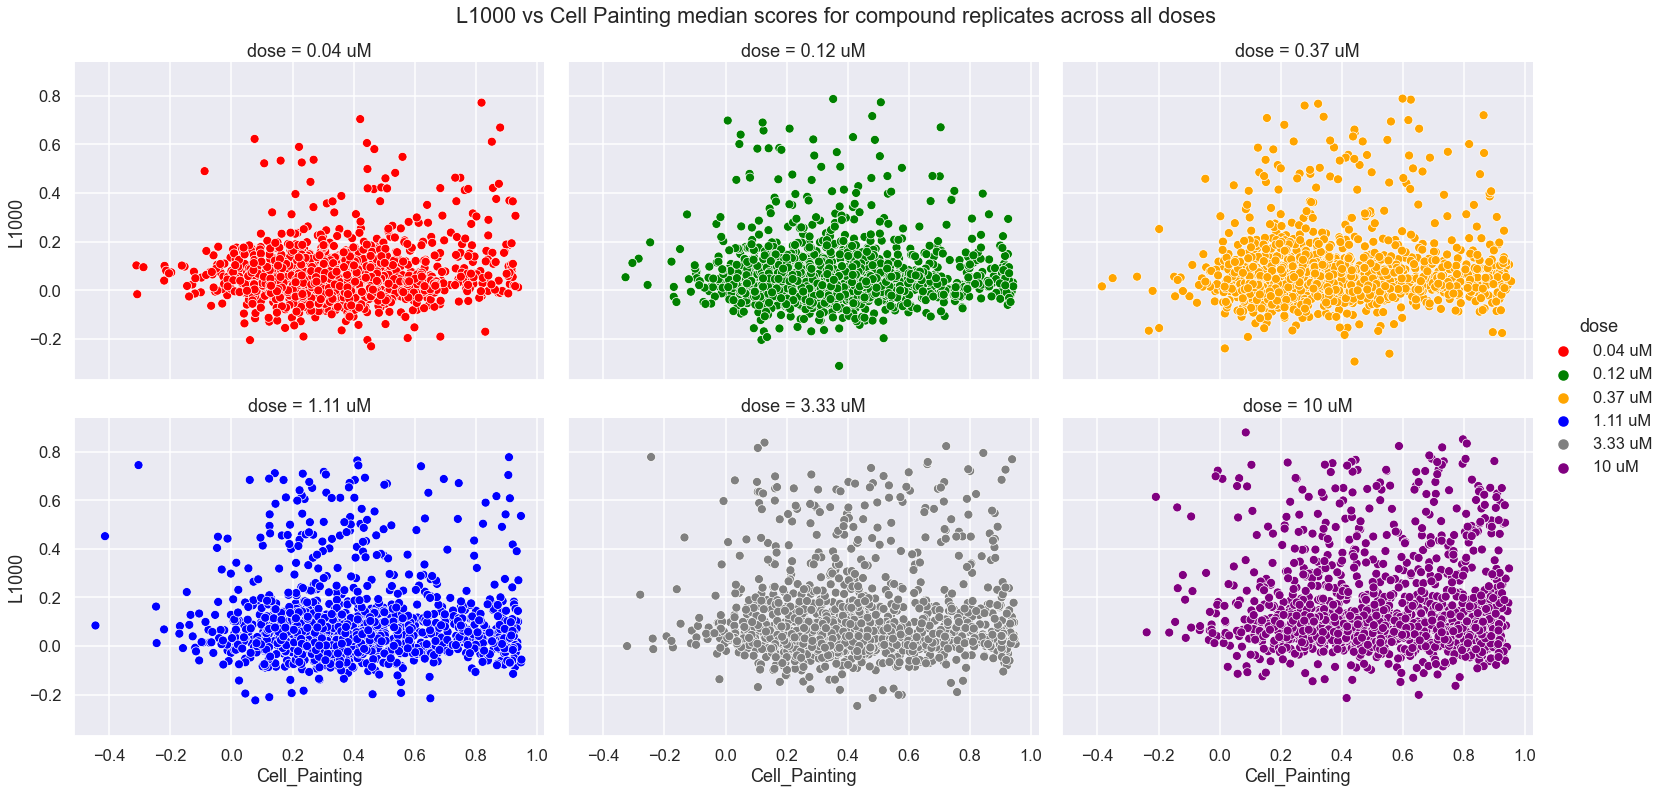

In [13]:
plot_median_scores(df_cp_L1_meds, "L1000 vs Cell Painting median scores for compound replicates across all doses",
                   'L1000_cp_figures', 'median_scores_plot.png')

In [14]:
def plot_median_distribution(df_median_scores, path, file_name, plot_type = "hist"):
    """
    This function plot the frequency distribution of the median scores 
    of compounds measured in cell painting and L1000
    """
    if not os.path.exists(path):
        os.mkdir(path)
        
    dist_plt = sns.displot(df_median_scores, x = 'median_scores', col = 'dose', col_wrap=3, hue='profile_tech',
                          height=5.5, aspect=1.1, kind=plot_type)
    dist_plt.legend.set_title("")
    dist_plt.fig.suptitle('Distribution of median scores across L1000 and Cell painting data per doses')
    dist_plt.fig.subplots_adjust(top=.90)
    plt.savefig(os.path.join(path, file_name))
    plt.show()

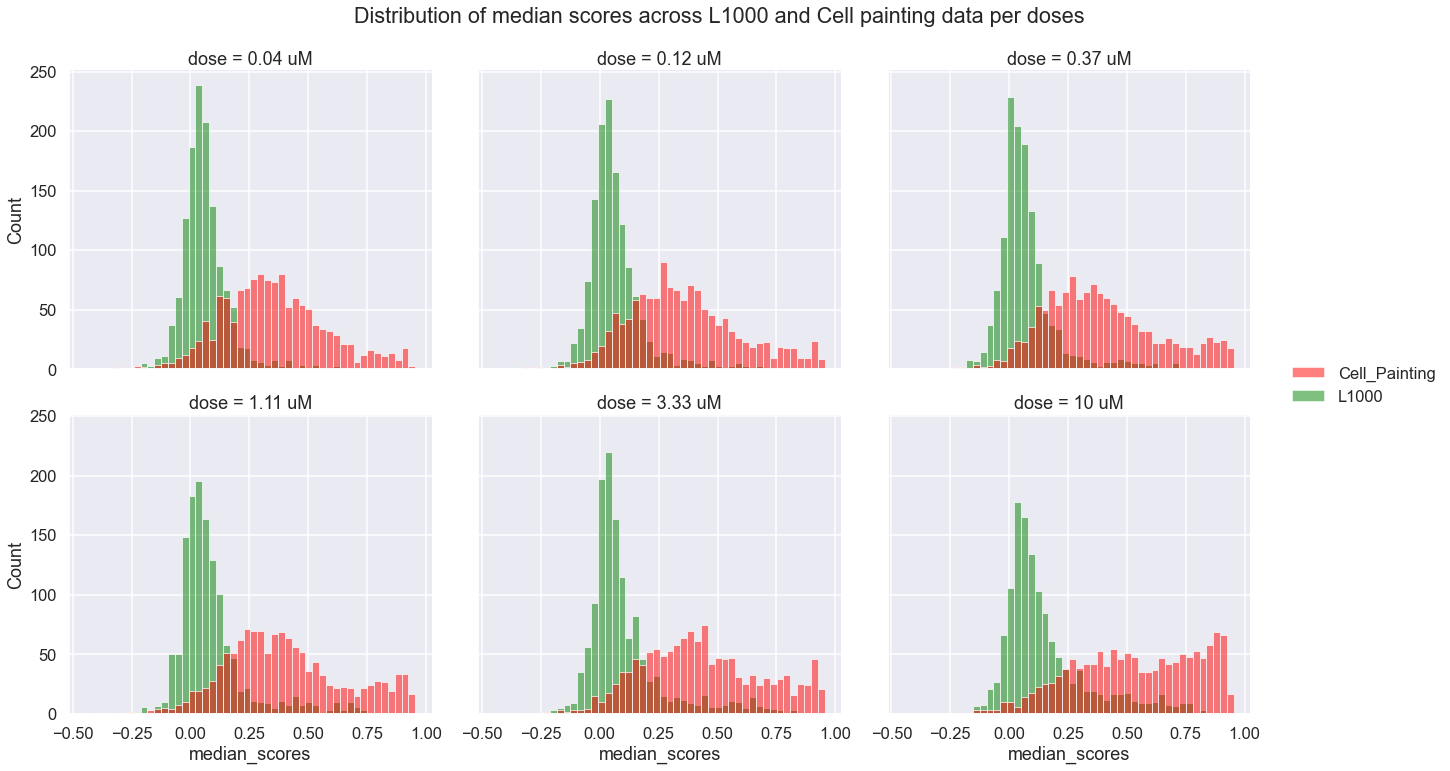

In [15]:
plot_median_distribution(df_median_scores, 'L1000_cp_figures', 'median_score_distribution.png')

In [16]:
def plot_median_dist(df, path, file_name):
    
    """
    This function plot the frequency distribution of the median scores 
    of compounds measured in cell painting and L1000
    """
    if not os.path.exists(path):
        os.mkdir(path)
        
    dist = sns.displot(df, x="median_scores", col="profile_tech", col_wrap=2, hue = 'dose', 
                       height=6.5, aspect=1.5, multiple="stack")
    dist.fig.suptitle('Distribution of median scores across L1000 and Cell painting data per doses')
    dist.fig.subplots_adjust(top=.85)
    axes = dist.axes.flatten()
    axes[0].set_title("Cell Painting")
    axes[1].set_title("L1000")
    plt.savefig(os.path.join(path, file_name))
    plt.show()

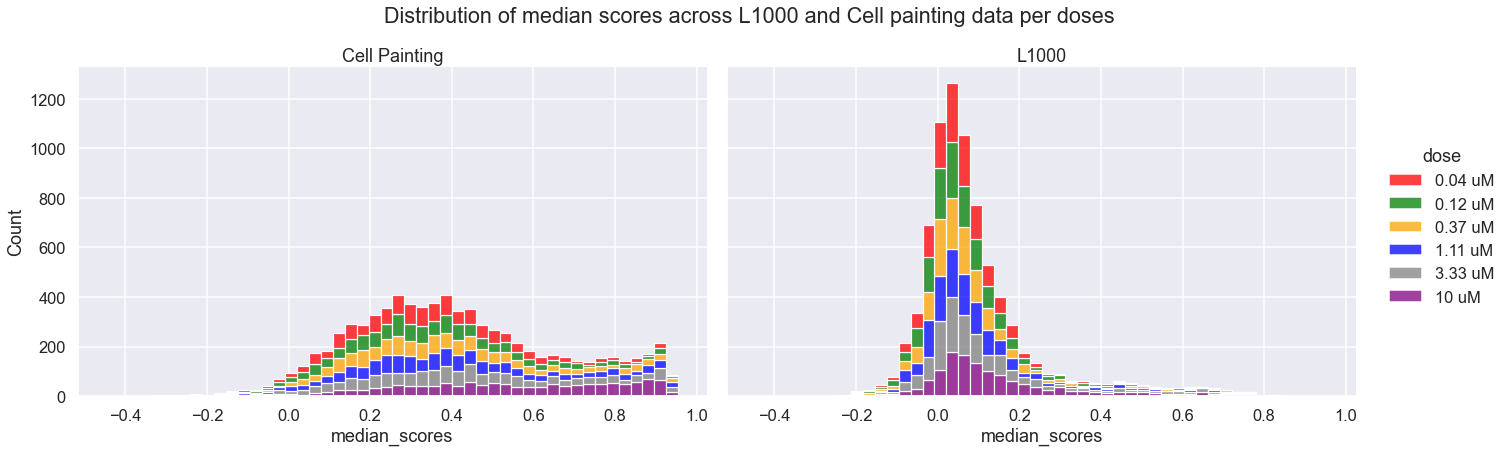

In [17]:
plot_median_dist(df_median_scores, 'L1000_cp_figures', 'median_score_dist.png')

### - Compounds with reproducible median correlation values (i.e. p_values below 0.05)

In [18]:
def no_of_cpds(stat_cp, stat_L1000, path, file_name):
    """Plot the number of compounds with reproducible median scores in both L1000 and cell painting"""
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    plt.figure(figsize=(12,8))
    sns.barplot(x=['cell painting', 'L1000'], y=[len(stat_cp), len(stat_L1000)], linewidth=2.5, errcolor=".2", edgecolor=".2")
    plt.xlabel('Profile technology', fontsize=15)
    plt.ylabel('Number of compounds', fontsize=15)
    plt.title('Number of compounds with reproducible median scores')
    plt.savefig(os.path.join(path, file_name))
    plt.show()

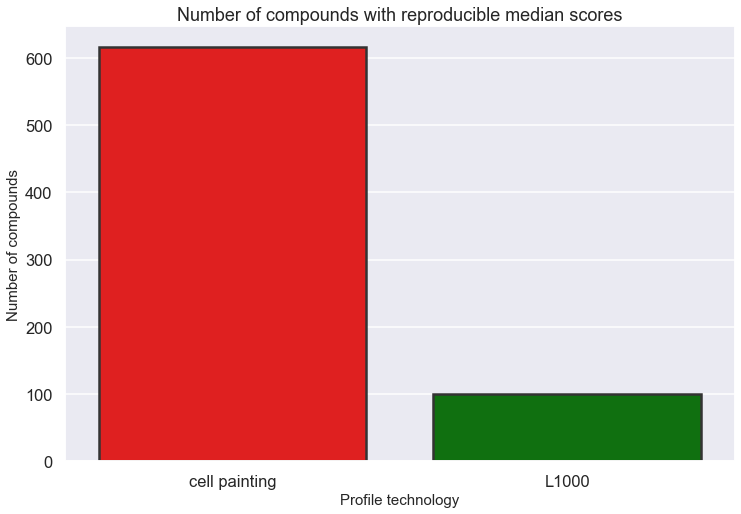

In [19]:
no_of_cpds(stat_cp, stat_L1000, 'L1000_cp_figures', 'no_of_cpds_reproducible.png')

In [20]:
def get_stat_sign_median_scores(stat_cp, stat_L1000, df):
    """
    This function returns dataframe with median scores of compounds 
    that are reproducible and found in both L1000 and Cell painting
    """
    
    stat_cp_l1000 = [idx for idx in stat_cp if idx in stat_L1000]
    df_new = df.set_index('cpd').rename_axis(None, axis=0).copy()
    df_stat = df_new.loc[stat_cp_l1000]
    
    return df_stat

In [21]:
df_stat_cp_L1 = get_stat_sign_median_scores(stat_cp, stat_L1000, df_cp_L1_meds)

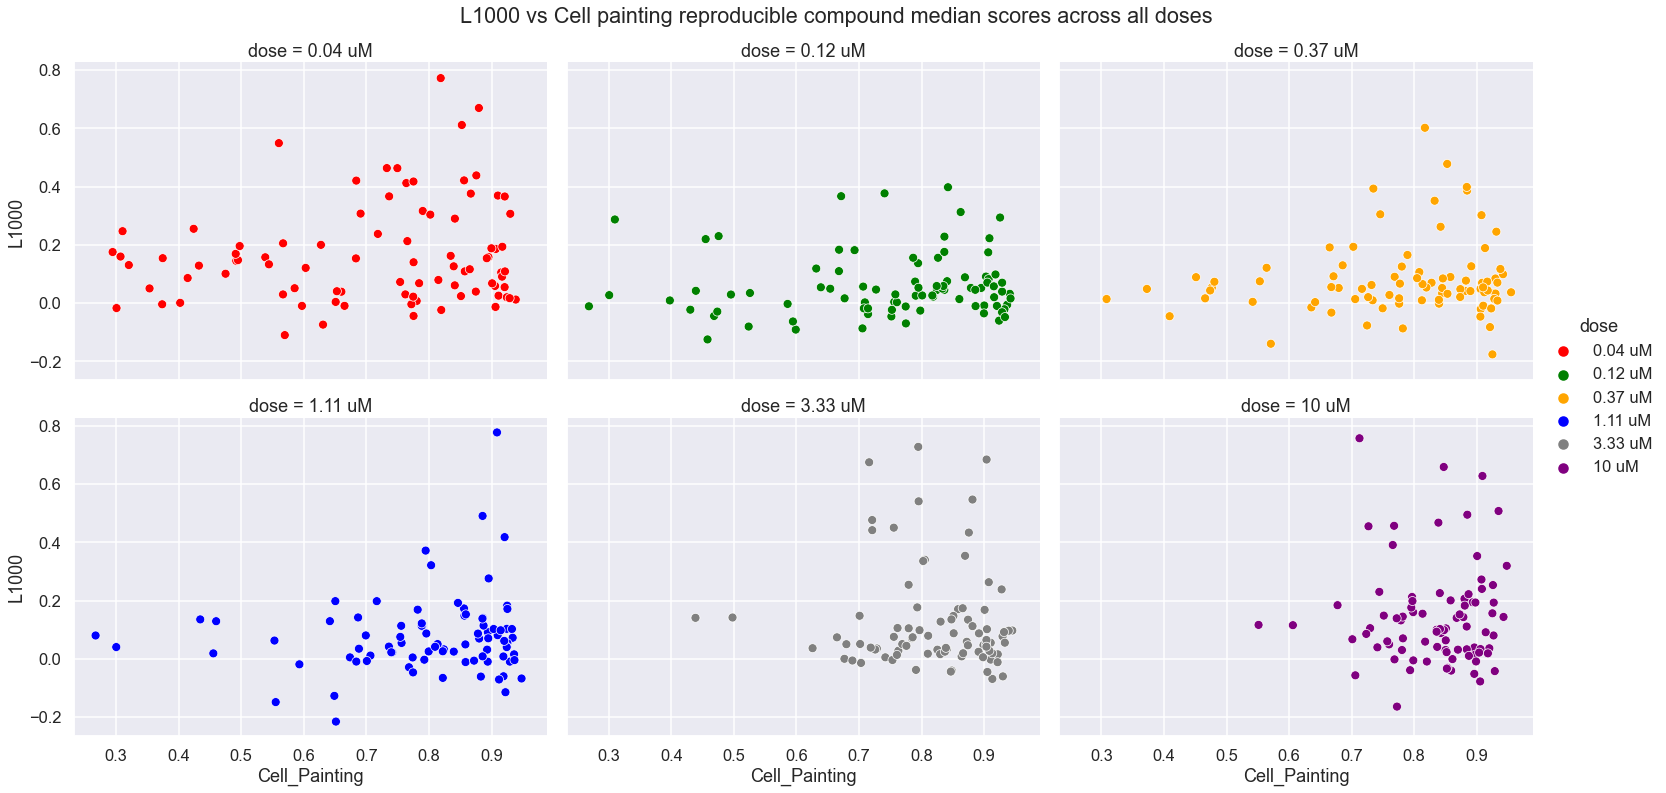

In [22]:
plot_median_scores(df_stat_cp_L1, "L1000 vs Cell painting reproducible compound median scores across all doses",
                   'L1000_cp_figures', 'stat_sign_med_scores_plot.png')